In [34]:
# Llamar 'QS_limpio.xlsx' y traer cada hoja en un DataFrame
import pandas as pd
import re

excel_path = 'QS_limpio.xlsx'  # archivo generado en la limpieza
sheets = pd.read_excel(excel_path, sheet_name=None)  # dict: {nombre_hoja: DataFrame}

# Crear variables globales por cada hoja con nombres válidos de Python
print('Hojas cargadas y variables creadas:')
for sheet_name, df in sheets.items():
    var_name = re.sub(r'\W|^(?=\d)', '_', sheet_name.strip().replace(' ', '_'))
    globals()[var_name] = df
    print(f" - {sheet_name} -> {var_name} (filas={df.shape[0]}, cols={df.shape[1]})")

# También dejar disponible el diccionario completo
hojas = sheets  # alias conveniente para acceder por nombre original

c:\Users\sergio_math\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


Hojas cargadas y variables creadas:
 - Avisados -> Avisados (filas=835, cols=11)
 - Siniestros -> Siniestros (filas=46582, cols=13)
 - Primas -> Primas (filas=13, cols=4)
 - Reaseguro -> Reaseguro (filas=38, cols=5)


In [35]:
# ===============================
# 1. Importar librerías y funciones necesarias
# ===============================
import pandas as pd  # Manejo de datos
from xgboost import XGBRegressor  # Modelo de regresión
from skforecast.recursive import ForecasterRecursive  # Forecasting recursivo
from skforecast.preprocessing import RollingFeatures  # Features de ventana
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster  # Validación y optimización
from sklearn.feature_selection import RFECV
from skforecast.feature_selection import select_features


siniestros_forecast = Siniestros[['Fecha de Ocurrencia', 'TOTAL SINIESTRO']].copy()
siniestros_forecast['Fecha de Ocurrencia'] = pd.to_datetime(siniestros_forecast['Fecha de Ocurrencia'], errors='coerce')

serie_m = (
    siniestros_forecast
    .set_index('Fecha de Ocurrencia')
    .sort_index()
    .resample('MS')['TOTAL SINIESTRO'].sum()
)

serie_m = serie_m.asfreq('MS').sort_index()

In [36]:
def split_data(df, len_train, len_val, variable):
    """
    Divide una serie de tiempo en conjuntos de entrenamiento, validación y prueba.

    Args:
        df (pd.DataFrame): DataFrame con la serie de tiempo (debe tener la columna 'TOTAL SINIESTRO').
        len_train (float): Proporción de datos para el conjunto de entrenamiento (ej: 0.7).
        len_val (float): Proporción de datos para el conjunto de validación (ej: 0.15).

    Returns:
        tuple: Tres DataFrames (data_train, data_val, data_test).
    """
    n = len(df)
    train_size = int(n * len_train)
    val_size = int(n * len_val)
    
    data_train = df.iloc[:train_size][[variable]]
    data_val = df.iloc[train_size : train_size + val_size][[variable]]
    data_test = df.iloc[train_size + val_size :][[variable]]

    return data_train, data_val, data_test


In [37]:
def opt_forecaster(data_train, data_val, data_test, variable):
    """
    Optimiza hiperparámetros, selecciona características y entrena un modelo
    Forecaster sin variables exógenas.

    Args:
        data_train (pd.DataFrame): Datos de entrenamiento.
        data_val (pd.DataFrame): Datos de validación.
        data_test (pd.DataFrame): Datos de prueba.

    Returns:
        ForecasterRecursive: El objeto forecaster entrenado y optimizado.
    """
    import warnings
    from sklearn.feature_selection import RFECV
    from skforecast.feature_selection import select_features
    # 1. Combinar datos para facilitar el manejo de índices
    serie = pd.concat([data_train, data_val, data_test])
    y_train_val = serie.iloc[:(len(data_train) + len(data_val))][variable]

    # 2. Definir el Forecaster inicial para la búsqueda
    forecaster = ForecasterRecursive(
        regressor=XGBRegressor(random_state=15926, enable_categorical=True),
        lags=6,
        window_features=[RollingFeatures(stats=['mean','mean','mean','mean','mean'], window_sizes=[1, 2, 3, 4, 6])]
    )

    # 3. Búsqueda Bayesiana de hiperparámetros
    lags_grid = [4, 3, 10, [1, 2, 3, 6, 12, 24]]
    def search_space(trial):
        return {
            'n_estimators'    : trial.suggest_int('n_estimators', 50, 1500, step=50),
            'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
            'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
            'subsample'       : trial.suggest_float('subsample', 0.1, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
            'gamma'           : trial.suggest_float('gamma', 0, 1),
            'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
            'lags'            : trial.suggest_categorical('lags', lags_grid)
        }

    cv_search = TimeSeriesFold(
        steps=len(data_val), initial_train_size=len(data_train), refit=True
    )
    
    results_search, frozen_trial = bayesian_search_forecaster(
        forecaster=forecaster, y=y_train_val, search_space=search_space,
        cv=cv_search, metric='mean_absolute_error', n_trials=50,
        show_progress=False, n_jobs=-1
    )
    
    best_params = results_search['params'].iat[0]
    best_lags = results_search['lags'].iat[0]

    # 4. Selección de características (Lags y Window Features)
    forecaster.fit(y=y_train_val)
    selector = RFECV(estimator=forecaster.regressor, step=1, cv=3, n_jobs=-1)
    
    lags_select, window_features_select, _ = select_features(
        forecaster=forecaster, selector=selector, y=y_train_val,
        subsample=0.5, random_state=123, verbose=False
    )
   
    # 5. Crear y entrenar el Forecaster final con los mejores parámetros
    if window_features_select:
        window_sizes = [int(i.split('_')[-1]) for i in window_features_select]
        window_stats = [i.split('_')[1] for i in window_features_select]
        final_window_features = [RollingFeatures(stats=window_stats, window_sizes=window_sizes)]
    else:
        final_window_features = None

    final_forecaster = ForecasterRecursive(
        regressor=XGBRegressor(**best_params, random_state=15926, enable_categorical=True),
        lags=lags_select if lags_select else best_lags,
        window_features=final_window_features,
    )

    final_forecaster.fit(y=serie[variable])

    return final_forecaster


In [38]:
# Asegurar que la función reciba un DataFrame con la columna esperada
serie_m_df = serie_m.to_frame(name='TOTAL SINIESTRO')
data_train, data_val, data_test = split_data(serie_m_df, 0.7, 0.15, variable='TOTAL SINIESTRO')
forecaster = opt_forecaster(data_train, data_val, data_test, variable='TOTAL SINIESTRO')
predictions = forecaster.predict(steps=18)

df_predictions = pd.DataFrame({
        "Fecha": predictions.index,
        "Valor": predictions.values,
})
df_predictions.head(50)

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.24844733874638825, 'subsample': 0.40911041264349246, 'colsample_bytree': 0.561815338779102, 'gamma': 0.6666245501640716, 'reg_alpha': 0.10590848505681383, 'reg_lambda': 0.13089495066408074}
  Backtesting metric: 1705713052.1460404


,Fecha,Valor
0,2025-01-01,-1.796216e+08
1,2025-02-01,1.173580e+09
2,2025-03-01,5.169015e+08
3,2025-04-01,4.974266e+08
4,2025-05-01,5.612075e+09
5,2025-06-01,7.846441e+09
6,2025-07-01,9.874025e+09
7,2025-08-01,1.186111e+10
8,2025-09-01,1.588148e+10
9,2025-10-01,1.860217e+10


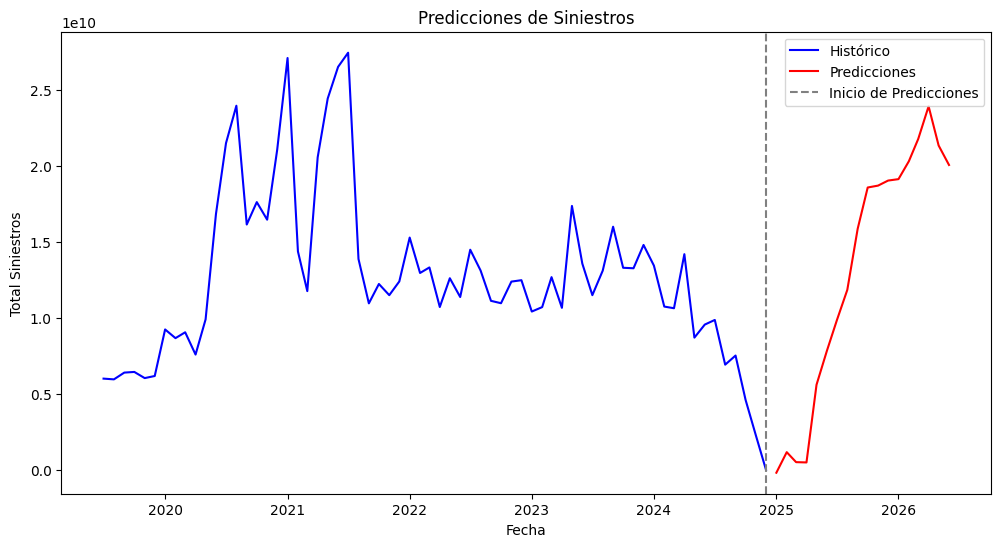

In [39]:
# Visualizar las predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie_m.index, serie_m.values, label='Histórico', color='blue')
plt.plot(df_predictions['Fecha'], df_predictions['Valor'], label='Predicciones', color='red')
plt.axvline(x=serie_m.index[-1], color='gray', linestyle='--', label='Inicio de Predicciones')
plt.title('Predicciones de Siniestros')
plt.xlabel('Fecha')
plt.ylabel('Total Siniestros')
plt.legend()
plt.show()

In [40]:
# exportar resultados
#df_predictions.to_csv('predicciones_siniestros.csv', index=False,sep=";",decimal=",")

In [41]:
#seleccionar de primas solo el año y la columna primas
primas_forecast=Primas[['Año Serie', 'Primas']]

In [42]:
primas_forecast['Año Serie'] = pd.to_datetime(primas_forecast['Año Serie'], format='%Y')
serie_m = primas_forecast.set_index('Año Serie').asfreq('YS').sort_index()
serie_m

C:\Users\sergio_math\AppData\Local\Temp\ipykernel_45128\3046654526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primas_forecast['Año Serie'] = pd.to_datetime(primas_forecast['Año Serie'], format='%Y')


,Primas
Año Serie,
2013-01-01,9.629617e+07
2014-01-01,5.660130e+07
2015-01-01,9.771145e+07
2016-01-01,1.094074e+08
2017-01-01,1.046538e+08
2018-01-01,1.245844e+08
2019-01-01,1.386031e+08
2020-01-01,1.425949e+08
2021-01-01,1.759379e+08


In [43]:
# Asegurar que la función reciba un DataFrame con la columna esperada
#serie_m_df = serie_m.to_frame(name='Primas')
data_train, data_val, data_test = split_data(serie_m, 0.7, 0.2, variable='Primas')
forecaster = opt_forecaster(data_train, data_val, data_test, variable='Primas')
predictions = forecaster.predict(steps=2)

df_predictions = pd.DataFrame({
        "Fecha": predictions.index,
        "Valor": predictions.values,
})
df_predictions.head(50)

Trial 0 failed with parameters: {'n_estimators': 1050, 'max_depth': 5, 'learning_rate': 0.2345829390285611, 'subsample': 0.5961832921746021, 'colsample_bytree': 0.7475220728070068, 'gamma': 0.42310646012446096, 'reg_alpha': 0.9807641983846155, 'reg_lambda': 0.6848297385848633, 'lags': [1, 2, 3, 6, 12, 24]} because of the following error: ValueError('If `initial_train_size` is an integer, it must be greater than the `window_size` of the forecaster (24) and smaller than the length of `y` (11). If it is a date, it must be within this range of the index.').
Traceback (most recent call last):
  File "c:\Users\sergio_math\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\sergio_math\anaconda3\Lib\site-packages\skforecast\model_selection\_search.py", line 772, in _objective
    metrics, _ = backtesting_forecaster(
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sergio_m

ValueError: If `initial_train_size` is an integer, it must be greater than the `window_size` of the forecaster (24) and smaller than the length of `y` (11). If it is a date, it must be within this range of the index.